# Učení neuronových sítí

https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_03_4_early_stop.ipynb

In [15]:
import torch

try:
    import google.colab

    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
device = (
    "mps"
    if getattr(torch, "has_mps", False)
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: cpu


## Příprava dat IRIS dataset

### Iris dataset čtení

In [9]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris.keys())
print(iris.DESCR)

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    peta

In [22]:
def namedata(data):
    return {
        'sepal_l': data[0],
        'sepal_w': data[1],
        'petal_l': data[2],
        'petal_w': data[3]
    }

table = list(map(namedata, iris.data))
table[:10]

[{'sepal_l': 5.1, 'sepal_w': 3.5, 'petal_l': 1.4, 'petal_w': 0.2},
 {'sepal_l': 4.9, 'sepal_w': 3.0, 'petal_l': 1.4, 'petal_w': 0.2},
 {'sepal_l': 4.7, 'sepal_w': 3.2, 'petal_l': 1.3, 'petal_w': 0.2},
 {'sepal_l': 4.6, 'sepal_w': 3.1, 'petal_l': 1.5, 'petal_w': 0.2},
 {'sepal_l': 5.0, 'sepal_w': 3.6, 'petal_l': 1.4, 'petal_w': 0.2},
 {'sepal_l': 5.4, 'sepal_w': 3.9, 'petal_l': 1.7, 'petal_w': 0.4},
 {'sepal_l': 4.6, 'sepal_w': 3.4, 'petal_l': 1.4, 'petal_w': 0.3},
 {'sepal_l': 5.0, 'sepal_w': 3.4, 'petal_l': 1.5, 'petal_w': 0.2},
 {'sepal_l': 4.4, 'sepal_w': 2.9, 'petal_l': 1.4, 'petal_w': 0.2},
 {'sepal_l': 4.9, 'sepal_w': 3.1, 'petal_l': 1.5, 'petal_w': 0.1}]

In [11]:
tmap = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
targets = list(map(lambda item: tmap[item], iris.target))

In [21]:
from IPython.display import JSON

table = [{**row, 'species': name} for row, name in zip(table, targets)]
JSON(table[:10])

<IPython.core.display.JSON object>

In [13]:
import pandas as pd
df = pd.DataFrame(table)
df

,sepal_l,sepal_w,petal_l,petal_w,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


### Data v matici

In [17]:
import time

import numpy as np
import pandas as pd
import torch
import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

def load_data():
    src = df.copy()

    le = LabelEncoder()

    x = src[["sepal_l", "sepal_w", "petal_l", "petal_w"]].values
    y = le.fit_transform(df["species"])
    species = le.classes_

    # Split into validation and training sets
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.25, random_state=42
    )

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Numpy to Torch Tensor
    x_train = torch.tensor(x_train, device=device, dtype=torch.float32)
    y_train = torch.tensor(y_train, device=device, dtype=torch.long)

    x_test = torch.tensor(x_test, device=device, dtype=torch.float32)
    y_test = torch.tensor(y_test, device=device, dtype=torch.long)

    return x_train, x_test, y_train, y_test, species


x_train, x_test, y_train, y_test, species = load_data()

## Cyklus učení

Problém přeučení - chyba klasifikace nejdříve klesá, 
tedy dochází ke zlepšení přesnosti klasifikace neuronovou sítí, 
ale od určitého okamžiku dochází k růstu této chyby a v dlouhodobém horizontu nedojde k poklesu.
Dochází k přeučení neuronové sítě.

In [26]:
import copy


class LearningMonitor:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        self.errors = []

    def __call__(self, model, val_loss):
        self.errors.append(val_loss)
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
#            if self.counter >= self.patience:
#                self.status = f"Early stopping triggered after {self.counter} epochs."
#                if self.restore_best_weights:
#                    model.load_state_dict(self.best_model)
#                return True
        return False

In [44]:
import time

import numpy as np
import pandas as pd
import torch
import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

# Create datasets
BATCH_SIZE = 16

dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(
    dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# Create model using nn.Sequential
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, len(species)),
    nn.LogSoftmax(dim=1),
)

model = torch.compile(model,backend="aot_eager").to(device)

loss_fn = nn.CrossEntropyLoss()  # cross entropy loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
es = LearningMonitor()

epoch = 0
done = False
while epoch < 100 and not done:
    epoch += 1
    steps = list(enumerate(dataloader_train))
    pbar = tqdm.tqdm(steps)
    model.train()
    for i, (x_batch, y_batch) in pbar:
        y_batch_pred = model(x_batch.to(device))
        loss = loss_fn(y_batch_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (i + 1) * len(x_batch)
        if i == len(steps) - 1:
            model.eval()
            pred = model(x_test)
            vloss = loss_fn(pred, y_test)
            if es(model, vloss):
                done = True
            pbar.set_description(
                f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, {es.status}"
            )
        else:
            pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")


Epoch: 1, tloss: 0.7625561952590942, vloss: 0.545046, : 100%|██████████| 7/7 [00:00<00:00, 34.68it/s]
Epoch: 2, tloss: 0.23402242362499237, vloss: 0.302025, Improvement found, counter reset to 0: 100%|██████████| 7/7 [00:00<00:00, 389.19it/s]
Epoch: 3, tloss: 0.2764117121696472, vloss: 0.172770, Improvement found, counter reset to 0: 100%|██████████| 7/7 [00:00<00:00, 352.23it/s]
Epoch: 4, tloss: 0.08428166061639786, vloss: 0.104354, Improvement found, counter reset to 0: 100%|██████████| 7/7 [00:00<00:00, 414.94it/s]
Epoch: 5, tloss: 0.22499683499336243, vloss: 0.063667, Improvement found, counter reset to 0: 100%|██████████| 7/7 [00:00<00:00, 383.96it/s]
Epoch: 6, tloss: 0.16208001971244812, vloss: 0.055089, Improvement found, counter reset to 0: 100%|██████████| 7/7 [00:00<00:00, 333.30it/s]
Epoch: 7, tloss: 0.02150058001279831, vloss: 0.068864, No improvement in the last 1 epochs: 100%|██████████| 7/7 [00:00<00:00, 427.58it/s]
Epoch: 8, tloss: 0.04294764623045921, vloss: 0.057677, 

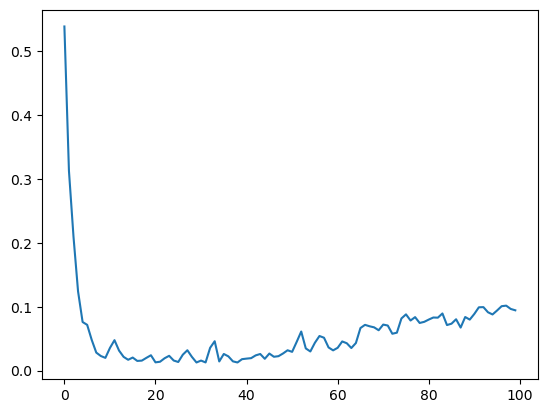

In [43]:
import matplotlib.pyplot as plt

e = [i.item() for i in es.errors]

plt.plot(e)

Důležitým

In [16]:
import copy


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

In [18]:
import time

import numpy as np
import pandas as pd
import torch
import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

# Create datasets
BATCH_SIZE = 16

dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(
    dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# Create model using nn.Sequential
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, len(species)),
    nn.LogSoftmax(dim=1),
)

model = torch.compile(model,backend="aot_eager").to(device)

loss_fn = nn.CrossEntropyLoss()  # cross entropy loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
es = EarlyStopping()

epoch = 0
done = False
while epoch < 1000 and not done:
    epoch += 1
    steps = list(enumerate(dataloader_train))
    pbar = tqdm.tqdm(steps)
    model.train()
    for i, (x_batch, y_batch) in pbar:
        y_batch_pred = model(x_batch.to(device))
        loss = loss_fn(y_batch_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (i + 1) * len(x_batch)
        if i == len(steps) - 1:
            model.eval()
            pred = model(x_test)
            vloss = loss_fn(pred, y_test)
            if es(model, vloss):
                done = True
            pbar.set_description(
                f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, {es.status}"
            )
        else:
            pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")

Epoch: 1, tloss: 0.6026307344436646, vloss: 0.536555, : 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]
Epoch: 2, tloss: 0.3658648133277893, vloss: 0.277725, Improvement found, counter reset to 0: 100%|██████████| 7/7 [00:00<00:00, 401.73it/s]
Epoch: 3, tloss: 0.15603026747703552, vloss: 0.187535, Improvement found, counter reset to 0: 100%|██████████| 7/7 [00:00<00:00, 414.63it/s]
Epoch: 4, tloss: 0.057948920875787735, vloss: 0.154333, Improvement found, counter reset to 0: 100%|██████████| 7/7 [00:00<00:00, 388.62it/s]
Epoch: 5, tloss: 0.18528974056243896, vloss: 0.076723, Improvement found, counter reset to 0: 100%|██████████| 7/7 [00:00<00:00, 396.41it/s]
Epoch: 6, tloss: 0.12420050799846649, vloss: 0.061499, Improvement found, counter reset to 0: 100%|██████████| 7/7 [00:00<00:00, 384.29it/s]
Epoch: 7, tloss: 0.03340417519211769, vloss: 0.045322, Improvement found, counter reset to 0: 100%|██████████| 7/7 [00:00<00:00, 426.23it/s]
Epoch: 8, tloss: 0.09452513605356216, vloss: 0.03297

## Regresní neuronové sítě

## Datová sada Auta

### Raw (surová data)

In [45]:
import aiohttp
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

async with aiohttp.ClientSession() as session:
    async with session.get(url) as resp:
        # print(resp.status)
        textresponse = await resp.text()
print(textresponse[:1000])

18.0   8   307.0      130.0      3504.      12.0   70  1	"chevrolet chevelle malibu"
15.0   8   350.0      165.0      3693.      11.5   70  1	"buick skylark 320"
18.0   8   318.0      150.0      3436.      11.0   70  1	"plymouth satellite"
16.0   8   304.0      150.0      3433.      12.0   70  1	"amc rebel sst"
17.0   8   302.0      140.0      3449.      10.5   70  1	"ford torino"
15.0   8   429.0      198.0      4341.      10.0   70  1	"ford galaxie 500"
14.0   8   454.0      220.0      4354.       9.0   70  1	"chevrolet impala"
14.0   8   440.0      215.0      4312.       8.5   70  1	"plymouth fury iii"
14.0   8   455.0      225.0      4425.      10.0   70  1	"pontiac catalina"
15.0   8   390.0      190.0      3850.       8.5   70  1	"amc ambassador dpl"
15.0   8   383.0      170.0      3563.      10.0   70  1	"dodge challenger se"
14.0   8   340.0      160.0      3609.       8.0   70  1	"plymouth 'cuda 340"
15.0   8   400.0      150.0      3761.       9.5   70  1	"chevrolet monte ca

### Reformat

In [46]:
import re
textresponse = re.sub(' +', ' ', textresponse)
textresponse = re.sub('\t', ' ', textresponse)
print(textresponse[:1000])

18.0 8 307.0 130.0 3504. 12.0 70 1 "chevrolet chevelle malibu"
15.0 8 350.0 165.0 3693. 11.5 70 1 "buick skylark 320"
18.0 8 318.0 150.0 3436. 11.0 70 1 "plymouth satellite"
16.0 8 304.0 150.0 3433. 12.0 70 1 "amc rebel sst"
17.0 8 302.0 140.0 3449. 10.5 70 1 "ford torino"
15.0 8 429.0 198.0 4341. 10.0 70 1 "ford galaxie 500"
14.0 8 454.0 220.0 4354. 9.0 70 1 "chevrolet impala"
14.0 8 440.0 215.0 4312. 8.5 70 1 "plymouth fury iii"
14.0 8 455.0 225.0 4425. 10.0 70 1 "pontiac catalina"
15.0 8 390.0 190.0 3850. 8.5 70 1 "amc ambassador dpl"
15.0 8 383.0 170.0 3563. 10.0 70 1 "dodge challenger se"
14.0 8 340.0 160.0 3609. 8.0 70 1 "plymouth 'cuda 340"
15.0 8 400.0 150.0 3761. 9.5 70 1 "chevrolet monte carlo"
14.0 8 455.0 225.0 3086. 10.0 70 1 "buick estate wagon (sw)"
24.0 4 113.0 95.00 2372. 15.0 70 3 "toyota corona mark ii"
22.0 6 198.0 95.00 2833. 15.5 70 1 "plymouth duster"
18.0 6 199.0 97.00 2774. 15.5 70 1 "amc hornet"
21.0 6 200.0 85.00 2587. 16.0 70 1 "ford maverick"
27.0 4 97.00 8

### Načtení do Pandas

In [56]:
import pandas as pd
from io import StringIO 


def getAutoDataFrame():
    df = pd.read_csv(StringIO(textresponse), sep=" ", names=["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin", "name"], na_values=["?"])
    return df

pd.set_option("display.max_columns", 7)

df = getAutoDataFrame()
df

,mpg,cylinders,displacement,...,year,origin,name
0,18.0,8,307.0,...,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,...,70,1,buick skylark 320
2,18.0,8,318.0,...,70,1,plymouth satellite
3,16.0,8,304.0,...,70,1,amc rebel sst
4,17.0,8,302.0,...,70,1,ford torino
...,...,...,...,...,...,...,...
393,27.0,4,140.0,...,82,1,ford mustang gl
394,44.0,4,97.0,...,82,2,vw pickup
395,32.0,4,135.0,...,82,1,dodge rampage
396,28.0,4,120.0,...,82,1,ford ranger


In [50]:
import time

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

cars = df["name"]

# Handle missing value
df["horsepower"] = df["horsepower"].fillna(df["horsepower"].median())

# Pandas to Numpy
x = df[
    [
        "cylinders",
        "displacement",
        "horsepower",
        "weight",
        "acceleration",
        "year",
        "origin",
    ]
].values
y = df["mpg"].values  # regression

# Split into validation and training sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42
)

# Numpy to Torch Tensor
x_train = torch.tensor(x_train, device=device, dtype=torch.float32)
y_train = torch.tensor(y_train, device=device, dtype=torch.float32)

x_test = torch.tensor(x_test, device=device, dtype=torch.float32)
y_test = torch.tensor(y_test, device=device, dtype=torch.float32)

## Cyklus učení

In [51]:
import time

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

# Create datasets
BATCH_SIZE = 16

dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)


# Create model

model = nn.Sequential(
    nn.Linear(x_train.shape[1], 50), 
    nn.ReLU(), 
    nn.Linear(50, 25), 
    nn.ReLU(), 
    nn.Linear(25, 1)
)

model = torch.compile(model, backend="aot_eager").to(device)

# Define the loss function for regression
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

es = EarlyStopping()

epoch = 0
done = False
while epoch < 1000 and not done:
    epoch += 1
    steps = list(enumerate(dataloader_train))
    pbar = tqdm.tqdm(steps)
    model.train()
    for i, (x_batch, y_batch) in pbar:
        y_batch_pred = model(x_batch).flatten()  #
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (i + 1) * len(x_batch)
        if i == len(steps) - 1:
            model.eval()
            pred = model(x_test).flatten()
            vloss = loss_fn(pred, y_test)
            if es(model, vloss):
                done = True
            pbar.set_description(
                f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, EStop:[{es.status}]"
            )
        else:
            pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")

Epoch: 1, tloss: 274.22125244140625, vloss: 228.667557, EStop:[]: 100%|██████████| 19/19 [00:00<00:00, 64.92it/s]
Epoch: 2, tloss: 216.6737060546875, vloss: 221.983841, EStop:[Improvement found, counter reset to 0]: 100%|██████████| 19/19 [00:00<00:00, 392.38it/s]
Epoch: 3, tloss: 86.37828063964844, vloss: 210.166153, EStop:[Improvement found, counter reset to 0]: 100%|██████████| 19/19 [00:00<00:00, 384.74it/s]
Epoch: 4, tloss: 167.41175842285156, vloss: 195.353607, EStop:[Improvement found, counter reset to 0]: 100%|██████████| 19/19 [00:00<00:00, 463.32it/s]
Epoch: 5, tloss: 130.61611938476562, vloss: 190.856918, EStop:[Improvement found, counter reset to 0]: 100%|██████████| 19/19 [00:00<00:00, 430.20it/s]
Epoch: 6, tloss: 285.1935729980469, vloss: 167.852676, EStop:[Improvement found, counter reset to 0]: 100%|██████████| 19/19 [00:00<00:00, 419.85it/s]
Epoch: 7, tloss: 184.75961303710938, vloss: 157.483383, EStop:[Improvement found, counter reset to 0]: 100%|██████████| 19/19 [00

Metrika

## Testování

In [52]:
from sklearn import metrics

# Measure RMSE error.  RMSE is common for regression.
pred = model(x_test)
score = torch.sqrt(torch.nn.functional.mse_loss(pred.flatten(), y_test))
print(f"Final score (RMSE): {score}")

Final score (RMSE): 2.820802688598633


In [53]:
y_test

tensor([33.0000, 28.0000, 19.0000, 13.0000, 14.0000, 27.0000, 24.0000, 13.0000,
        17.0000, 21.0000, 15.0000, 38.0000, 26.0000, 15.0000, 25.0000, 12.0000,
        31.0000, 17.0000, 16.0000, 31.0000, 22.0000, 22.0000, 22.0000, 33.5000,
        18.0000, 44.0000, 26.0000, 24.5000, 18.1000, 12.0000, 27.0000, 36.0000,
        23.0000, 24.0000, 37.2000, 16.0000, 21.0000, 19.2000, 16.0000, 29.0000,
        26.8000, 27.0000, 18.0000, 10.0000, 23.0000, 36.0000, 26.0000, 25.0000,
        25.0000, 25.0000, 22.0000, 34.1000, 32.4000, 13.0000, 23.5000, 14.0000,
        18.5000, 29.8000, 28.0000, 19.0000, 11.0000, 33.0000, 23.0000, 21.0000,
        23.0000, 25.0000, 23.8000, 34.4000, 24.5000, 13.0000, 34.7000, 14.0000,
        15.0000, 18.0000, 25.0000, 19.9000, 17.5000, 28.0000, 29.0000, 17.0000,
        16.0000, 27.0000, 37.0000, 36.1000, 23.0000, 14.0000, 32.8000, 29.9000,
        20.0000, 12.0000, 15.5000, 23.7000, 24.0000, 36.0000, 19.0000, 38.0000,
        29.0000, 21.5000, 27.9000, 14.00

## Persistence neuronových sítí

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [57]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# For reproducibility
torch.manual_seed(0)
np.random.seed(0)

df = getAutoDataFrame()

# Handle missing value
df["horsepower"] = df["horsepower"].fillna(df["horsepower"].median())

# Select features and target
features = df[
    [
        "cylinders",
        "displacement",
        "horsepower",
        "weight",
        "acceleration",
        "year",
        "origin",
    ]
]
target = df["mpg"]

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert Numpy to PyTorch tensors
features_tensor = torch.tensor(
    scaled_features, device=device, dtype=torch.float32)
target_tensor = torch.tensor(target.values, device=device, dtype=torch.float32)

# Convert to TensorDataset
dataset = TensorDataset(features_tensor, target_tensor)

# Convert to DataLoader
data_loader = DataLoader(dataset, batch_size=32)

# Define the neural network using nn.Sequential
model = nn.Sequential(
    nn.Linear(features_tensor.shape[1], 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, 1),
).to(device)

# Define the loss function for regression
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train for 1000 epochs.
model.train()
for epoch in range(1000):
    for batch_features, batch_target in data_loader:
        optimizer.zero_grad()
        out = model(batch_features).flatten()
        loss = loss_fn(out, batch_target)
        loss.backward()
        optimizer.step()

    # Display status every 100 epochs.
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, loss: {loss.item()}")

model.eval()
pred = model(features_tensor)

# Measure RMSE error.  RMSE is common for regression.
score = torch.sqrt(torch.nn.functional.mse_loss(pred.flatten(), target_tensor))
print(f"Before save score (RMSE): {score}")
torch.save(model, "mpg.pkl")

Epoch 0, loss: 743.8233032226562
Epoch 100, loss: 14.93317985534668
Epoch 200, loss: 10.450526237487793
Epoch 300, loss: 9.245132446289062
Epoch 400, loss: 5.859930992126465
Epoch 500, loss: 6.295112609863281
Epoch 600, loss: 3.8231074810028076
Epoch 700, loss: 3.4604430198669434
Epoch 800, loss: 3.8247644901275635
Epoch 900, loss: 3.213823080062866
Before save score (RMSE): 1.9469631910324097


In [58]:
import torch

model = torch.load("mpg.pkl")

# Measure RMSE error for loaded network.  RMSE is common for regression.

model.eval()
pred = model(features_tensor)
score = torch.sqrt(torch.nn.functional.mse_loss(pred.flatten(), target_tensor))
print(f"Before save score (RMSE): {score}")
torch.save(model, "mpg.pkl")

Before save score (RMSE): 1.9469631910324097
